# Test biaslyze with disaster tweets data

Data source: https://www.kaggle.com/competitions/nlp-getting-started/overview

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/tobias/Repositories/biaslyze/')

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Load and prepare data

In [4]:
df = pd.read_csv("../data/disaster-tweets/train.csv"); df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [5]:
df.shape

(7613, 5)

In [6]:
# replace urls
import re
url_regex = re.compile("(http|https)://[\w\-]+(\.[\w\-]+)+\S*")

df = df.replace(to_replace=url_regex, value='', regex=True)

## Train a model

In [7]:
clf = make_pipeline(TfidfVectorizer(min_df=5, max_features=10000, stop_words="english"), LogisticRegression(n_jobs=4, C=20))

In [8]:
clf.fit(df.text, df.target)

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000, min_df=5,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(C=20, n_jobs=4))])

In [9]:
train_pred = clf.predict(df.text)
print(accuracy_score(df.target, train_pred))

0.9068698279259162


## Test detection of concepts

In [14]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
key_detect = KeywordConceptDetector()

In [16]:
detected_tweets = key_detect.detect(texts=df.text[:600])

2023-04-21 11:05:01.919 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 600 texts...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 51444.92it/s]
2023-04-21 11:05:01.939 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 412 texts with protected concepts.


In [17]:
len(detected_tweets)

412

In [18]:
detected_tweets

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 '#Flood in Bago Myanmar #We arrived Bago',
 "What's up man?",
 'this is ridiculous....',
 'Love my girlfriend',
 'The end!',
 'We always try to bring the he

## Test LIME based bias detection with keywords

In [19]:
from biaslyze.bias_detectors import LimeKeywordBiasDetector

In [20]:
bias_detector = LimeKeywordBiasDetector(bias_evaluator=LimeBiasEvaluator(n_lime_samples=500), n_top_keywords=30, use_tokenizer=True)

In [21]:
detection_res = bias_detector.detect(texts=df.text.sample(frac=0.3), predict_func=clf.predict_proba)

2023-04-21 11:05:08.905 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 2284 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2284/2284 [00:30<00:00, 74.87it/s]
2023-04-21 11:05:39.416 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 373 texts with protected concepts.
2023-04-21 11:05:39.417 | INFO     | biaslyze.evaluators:evaluate:44 - Started bias detection on 373 samples...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 373/373 [01:41<00:00,  3.66it/s]


In [22]:
detection_res.summary()

Detected 357 samples with potential issues.
    Potentially problematic concepts detected: [('gender', 209), ('nationality', 145), ('religion', 14)]
    Based on keywords: [('he', 50), ('california', 33), ('his', 31), ('her', 30), ('man', 25), ('she', 21), ('japan', 17), ('girl', 14), ('saudi', 14), ('women', 12), ('russian', 12), ('woman', 10), ('islam', 8), ('guys', 8), ('pakistan', 8), ('men', 7), ('russia', 7), ('australia', 7), ('boy', 7), ('israeli', 6)].


In [23]:
detection_res.details(group_by_concept=True)

Concept: nationality
[{'reason': ['california'],
  'text': 'California is battling its scariest 2015 wildfire so far - the '
          'Rocky Fire '},
 {'reason': ['israeli', 'muslims', 'christian'],
  'text': 'Christian Attacked by Muslims at the Temple Mount after Waving '
          'Israeli Flag via Pamela Geller - ... '},
 {'reason': ['california'],
  'text': 'Arson suspect linked to 30 fires caught in Northern California '},
 {'reason': ['finnish'],
  'text': 'Finnish ministers: Fennovoima nuclear reactor will go ahead '},
 {'reason': ['saudi'],
  'text': 'Mosque bombing strikes Saudi special forces; at least 15 people '
          'dead: A suicide bomber struck a mosque i...  #news'},
 {'reason': ['russia'],
  'text': "'Food crematoria' in Russia provoke outrage amid crisis famine "
          'memories\n'},
 {'reason': ['saudi', 'arabia'],
  'text': 'FCO Minister @Tobias_Ellwood condemns attack at a mosque in Saudi '
          'Arabia that has resulted in at least 15 deaths '},
 {

In [24]:
from bokeh.io import show, output_notebook

output_notebook()

In [43]:
dashboard = detection_res.dashboard()
show(dashboard)

In [25]:
pos_dashboard = detection_res.dashboard(use_position=True)
show(pos_dashboard)

## Try to cluster detected biases

In [26]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

In [27]:
# Prepare embeddings
docs = [sample.text for sample in detection_res.biased_samples]
y = [", ".join(sample.bias_concepts) for sample in detection_res.biased_samples]
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')
# Train BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model).fit(docs, embeddings)

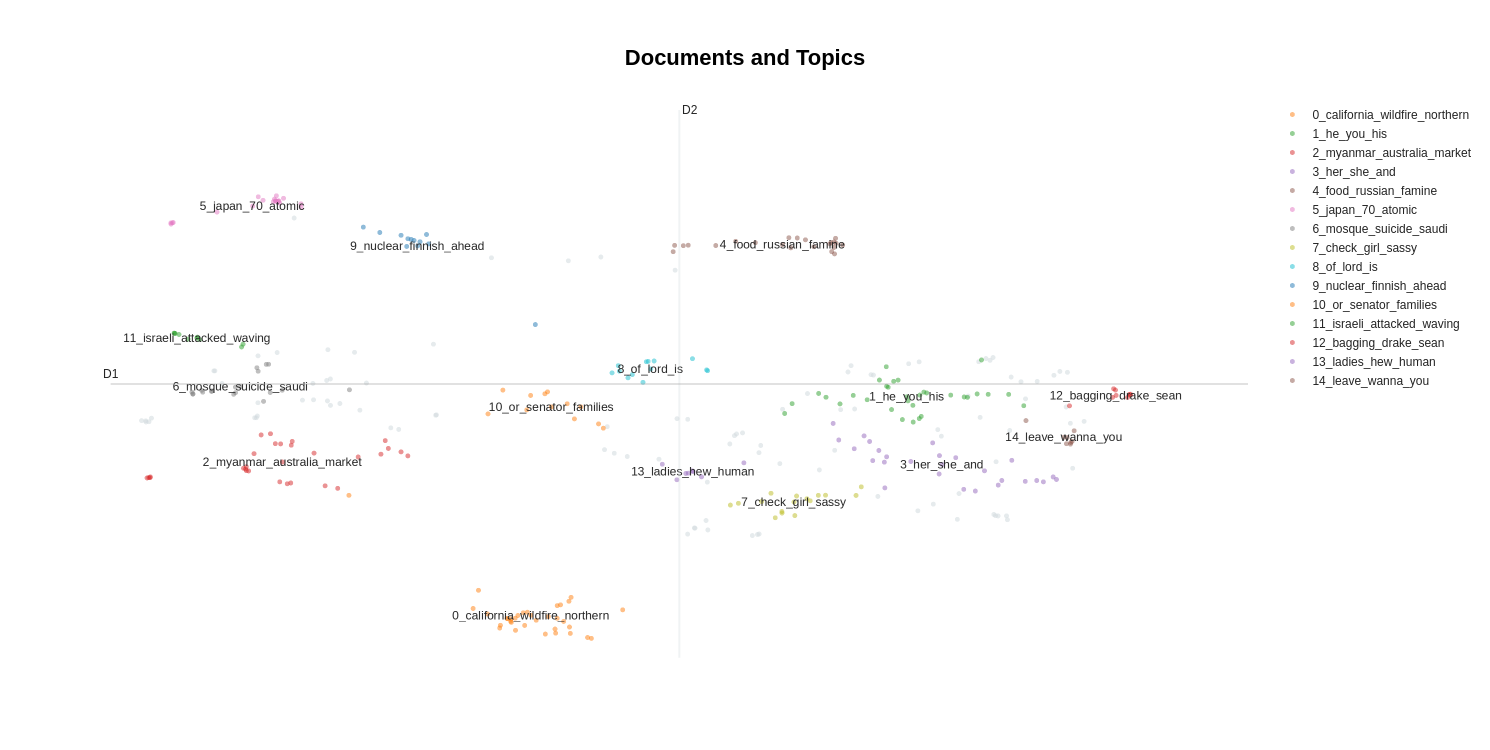

In [28]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(docs, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)

In [29]:
topic_model.topic_labels_

{-1: '-1_to_in_man_the',
 0: '0_california_wildfire_northern_fires',
 1: '1_he_you_his_hes',
 2: '2_myanmar_australia_market_in',
 3: '3_her_she_and_mom',
 4: '4_food_russian_famine_amid',
 5: '5_japan_70_atomic_years',
 6: '6_mosque_suicide_saudi_bomber',
 7: '7_check_girl_sassy_ibooklove',
 8: '8_of_lord_is_ur',
 9: '9_nuclear_finnish_ahead_will',
 10: '10_or_senator_families_alarmed',
 11: '11_israeli_attacked_waving_temple',
 12: '12_bagging_drake_sean_body',
 13: '13_ladies_hew_human_womens',
 14: '14_leave_wanna_you_that'}

In [30]:
topic_model.topic_embeddings_

In [41]:
import yaml
from bokeh.themes import Theme
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, TextInput, HoverTool
from bokeh.palettes import Spectral5, Accent5, Category10_5, Category10_10
from bokeh.io import curdoc
from bokeh.layouts import column, row


def bkapp(doc):
    hover_tool = HoverTool(tooltips=[("Text", "@text"), ("Keywords", "@keywords")])
    p = figure(width=1200, height=800, tools=["pan","wheel_zoom","box_zoom","reset", hover_tool])

    bias_concept = [",".join(sample.bias_concepts) for sample in detection_res.biased_samples]
    concept2int = list(set(bias_concept))
    num_bias_concept = [concept2int.index(c) for c in bias_concept]
    bias_intensity = [50*np.abs(sample.score) for sample in detection_res.biased_samples]

    # configure
    df = pd.DataFrame(dict(
        text=[sample.text for sample in detection_res.biased_samples],
        keywords=[",".join(sample.bias_reasons) for sample in detection_res.biased_samples],
        x=reduced_embeddings[:,0],
        y=reduced_embeddings[:,1],
        color=[Category10_10[idx] for idx in num_bias_concept],
        bias_intensity=bias_intensity,
        bias_concept=bias_concept,
    ))
    source = ColumnDataSource(data=df)

    # add a circle renderer with a size, color, and alpha
    p.scatter(
        "x", "y",
        source=source,
        color="color",
        size="bias_intensity",
        alpha=0.3,
        legend_group="bias_concept",
    )

    p.legend.location = "top_left"
    #p.legend.click_policy="hide"

    # slider
    threshold = Slider(title="threshold", value=0.0, start=0.0, end=1.0, step=0.01, width=750)

    def update_data(attrname, old, new):
        # Get the current slider values
        t = threshold.value
        new_df = df.copy()
        new_df["bias_intensity"] = new_df.bias_intensity.apply(lambda x: x if x >= 50*t else 0.0)
        source.data = new_df

    threshold.on_change('value', update_data)


    doc.add_root(column(threshold, p, width=800))
    # show the results
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 800
                width: 1200
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp)

## Testing a sentiment analysis model from huggingface

In [ ]:
from transformers import pipeline
from torch.utils.data import Dataset


classifier = pipeline(
    model="distilbert-base-uncased-finetuned-sst-2-english",
    top_k=None,
    padding=True,
    truncation=True
)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


def predict_sentiment(texts):
    data = MyDataset(texts)
    proba = []
    for res in classifier(data):
        proba_array = []
        for p in sorted(res, key=lambda d: d['label'], reverse=True):
            proba_array.append(p.get("score"))
        proba.append(np.array(proba_array))
    return np.array(proba) / np.array(proba).sum(axis=1)[:,None]

In [ ]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=500),
    n_top_keywords=10,
    use_tokenizer=True
)

In [ ]:
test_texts = detected_tweets[:10]
detection_res = bias_detector.detect(texts=test_texts, predict_func=predict_sentiment)

In [ ]:
detection_res.summary()

In [ ]:
detection_res.details(group_by_concept=True)

## !! Very Experimental !!: Test masked language model based bias detection with keywords

In [94]:
from biaslyze.bias_detectors import MaskedKeywordBiasDetector
from bokeh.io import show, output_notebook

output_notebook()

Loading BokehJS ...

In [102]:
bias_detector = MaskedKeywordBiasDetector(n_resample_keywords=30, use_tokenizer=True)

In [103]:
masked_detection_res = bias_detector.detect(texts=df.text.sample(frac=0.5), predict_func=clf.predict_proba)

2023-04-21 11:40:55.088 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 3806 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3806/3806 [00:45<00:00, 82.92it/s]
2023-04-21 11:41:40.990 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 608 texts with protected concepts.
2023-04-21 11:41:40.991 | INFO     | biaslyze.evaluators:evaluate:109 - Started bias detection on 608 samples...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 608/608 [00:25<00:00, 23.98it/s]


In [104]:
masked_detection_res.summary()

Detected 608 samples with potential issues.
    Potentially problematic concepts detected: [('gender', 386), ('nationality', 210), ('religion', 27)]
    Based on keywords: [('man', 104), ('he', 102), ('california', 57), ('her', 55), ('his', 47), ('she', 43), ('girl', 42), ('boy', 28), ('japan', 24), ('christian', 18), ('woman', 17), ('guys', 17), ('saudi', 16), ('men', 16), ('israeli', 15), ('china', 14), ('women', 14), ('muslims', 12), ('mom', 12), ('australia', 12)].


In [105]:
#masked_detection_res.details()

In [106]:
masked_detection_res.biased_samples[0].score

0.05010206359752136

In [108]:
dashboard = masked_detection_res.dashboard()
show(dashboard)

## Experiment with global importance of concept-keywords

In [10]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator, MaskedBiasEvaluator
from tqdm import tqdm
from biaslyze.concepts import CONCEPTS
import matplotlib.pyplot as plt
from biaslyze.counterfactual_score import plot_scores, calculate_all_scores

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
key_detect = KeywordConceptDetector()

In [12]:
detected_texts = key_detect.detect(texts=df.text)

2023-05-05 11:38:53.162 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 7613 texts...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7613/7613 [00:00<00:00, 10284.85it/s]
2023-05-05 11:38:53.907 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 6041 texts with protected concepts.


In [13]:
len(detected_texts)

6041

In [14]:
score_df = calculate_all_scores(texts=detected_texts, concept="gender", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
6041it [00:14, 403.56it/s]


Extracted 1528 sample texts for concept gender


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:09<00:00,  8.16it/s]


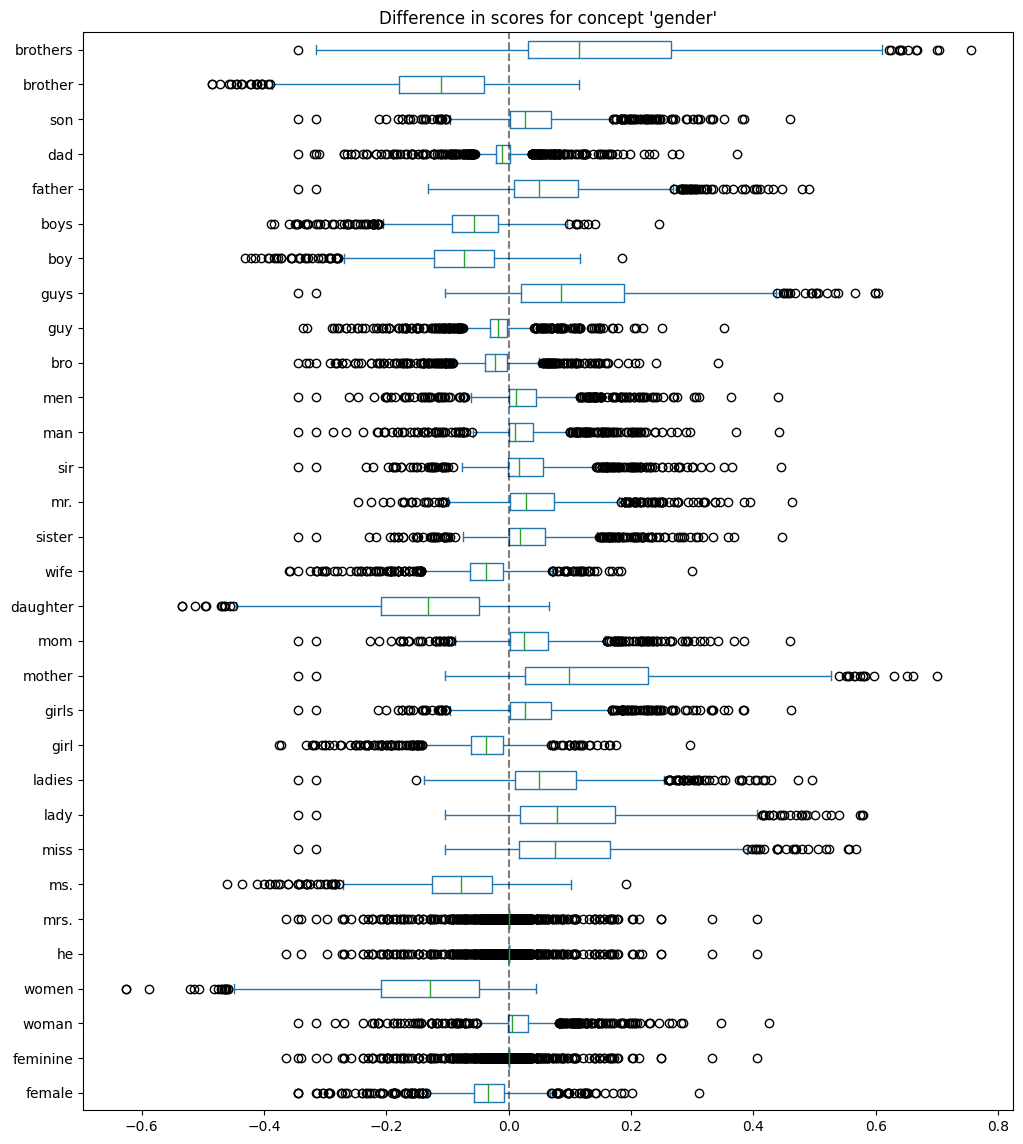

In [15]:
plot_scores(dataf=score_df, concept="gender")

SenseScore: 0.070505 (+- 0.081924)


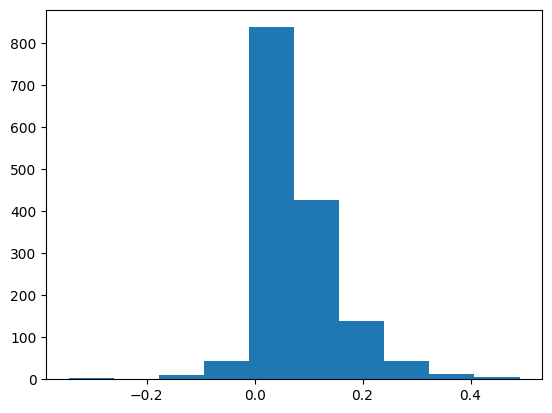

In [16]:
bias_keyword = "father"

score_diffs = score_df[bias_keyword].values
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

SenseScore: 0.03954 (+- 0.062759)


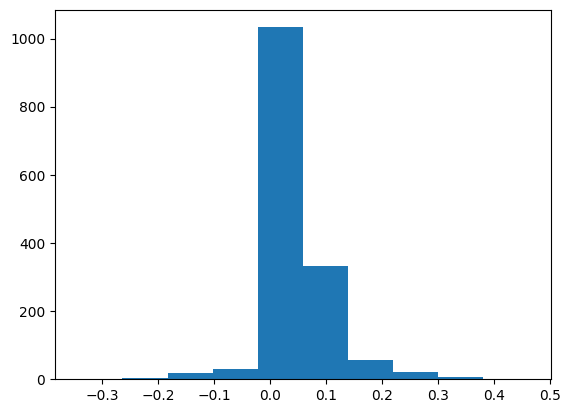

In [17]:
bias_keyword = "mom"

score_diffs = score_df[bias_keyword].values
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

In [18]:
religion_score_df = calculate_all_scores(texts=detected_texts, concept="religion", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
6041it [00:13, 433.24it/s]


Extracted 1528 sample texts for concept gender


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.83it/s]


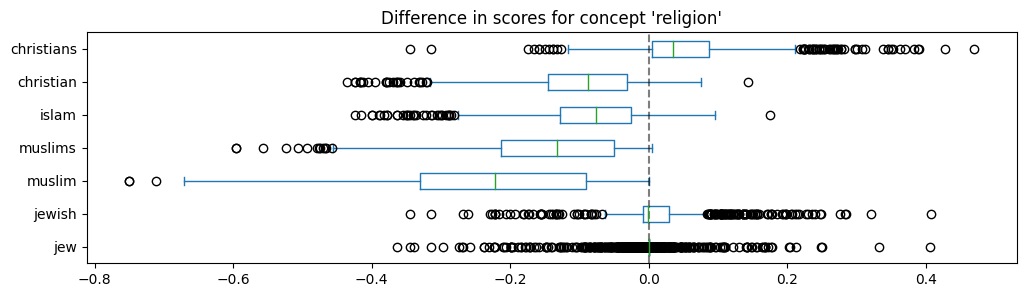

In [19]:
plot_scores(dataf=religion_score_df, concept="religion")

In [20]:
nationality_score_df = calculate_all_scores(texts=detected_texts, concept="nationality", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
6041it [00:14, 425.03it/s]


Extracted 1528 sample texts for concept gender


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 472/472 [00:50<00:00,  9.35it/s]


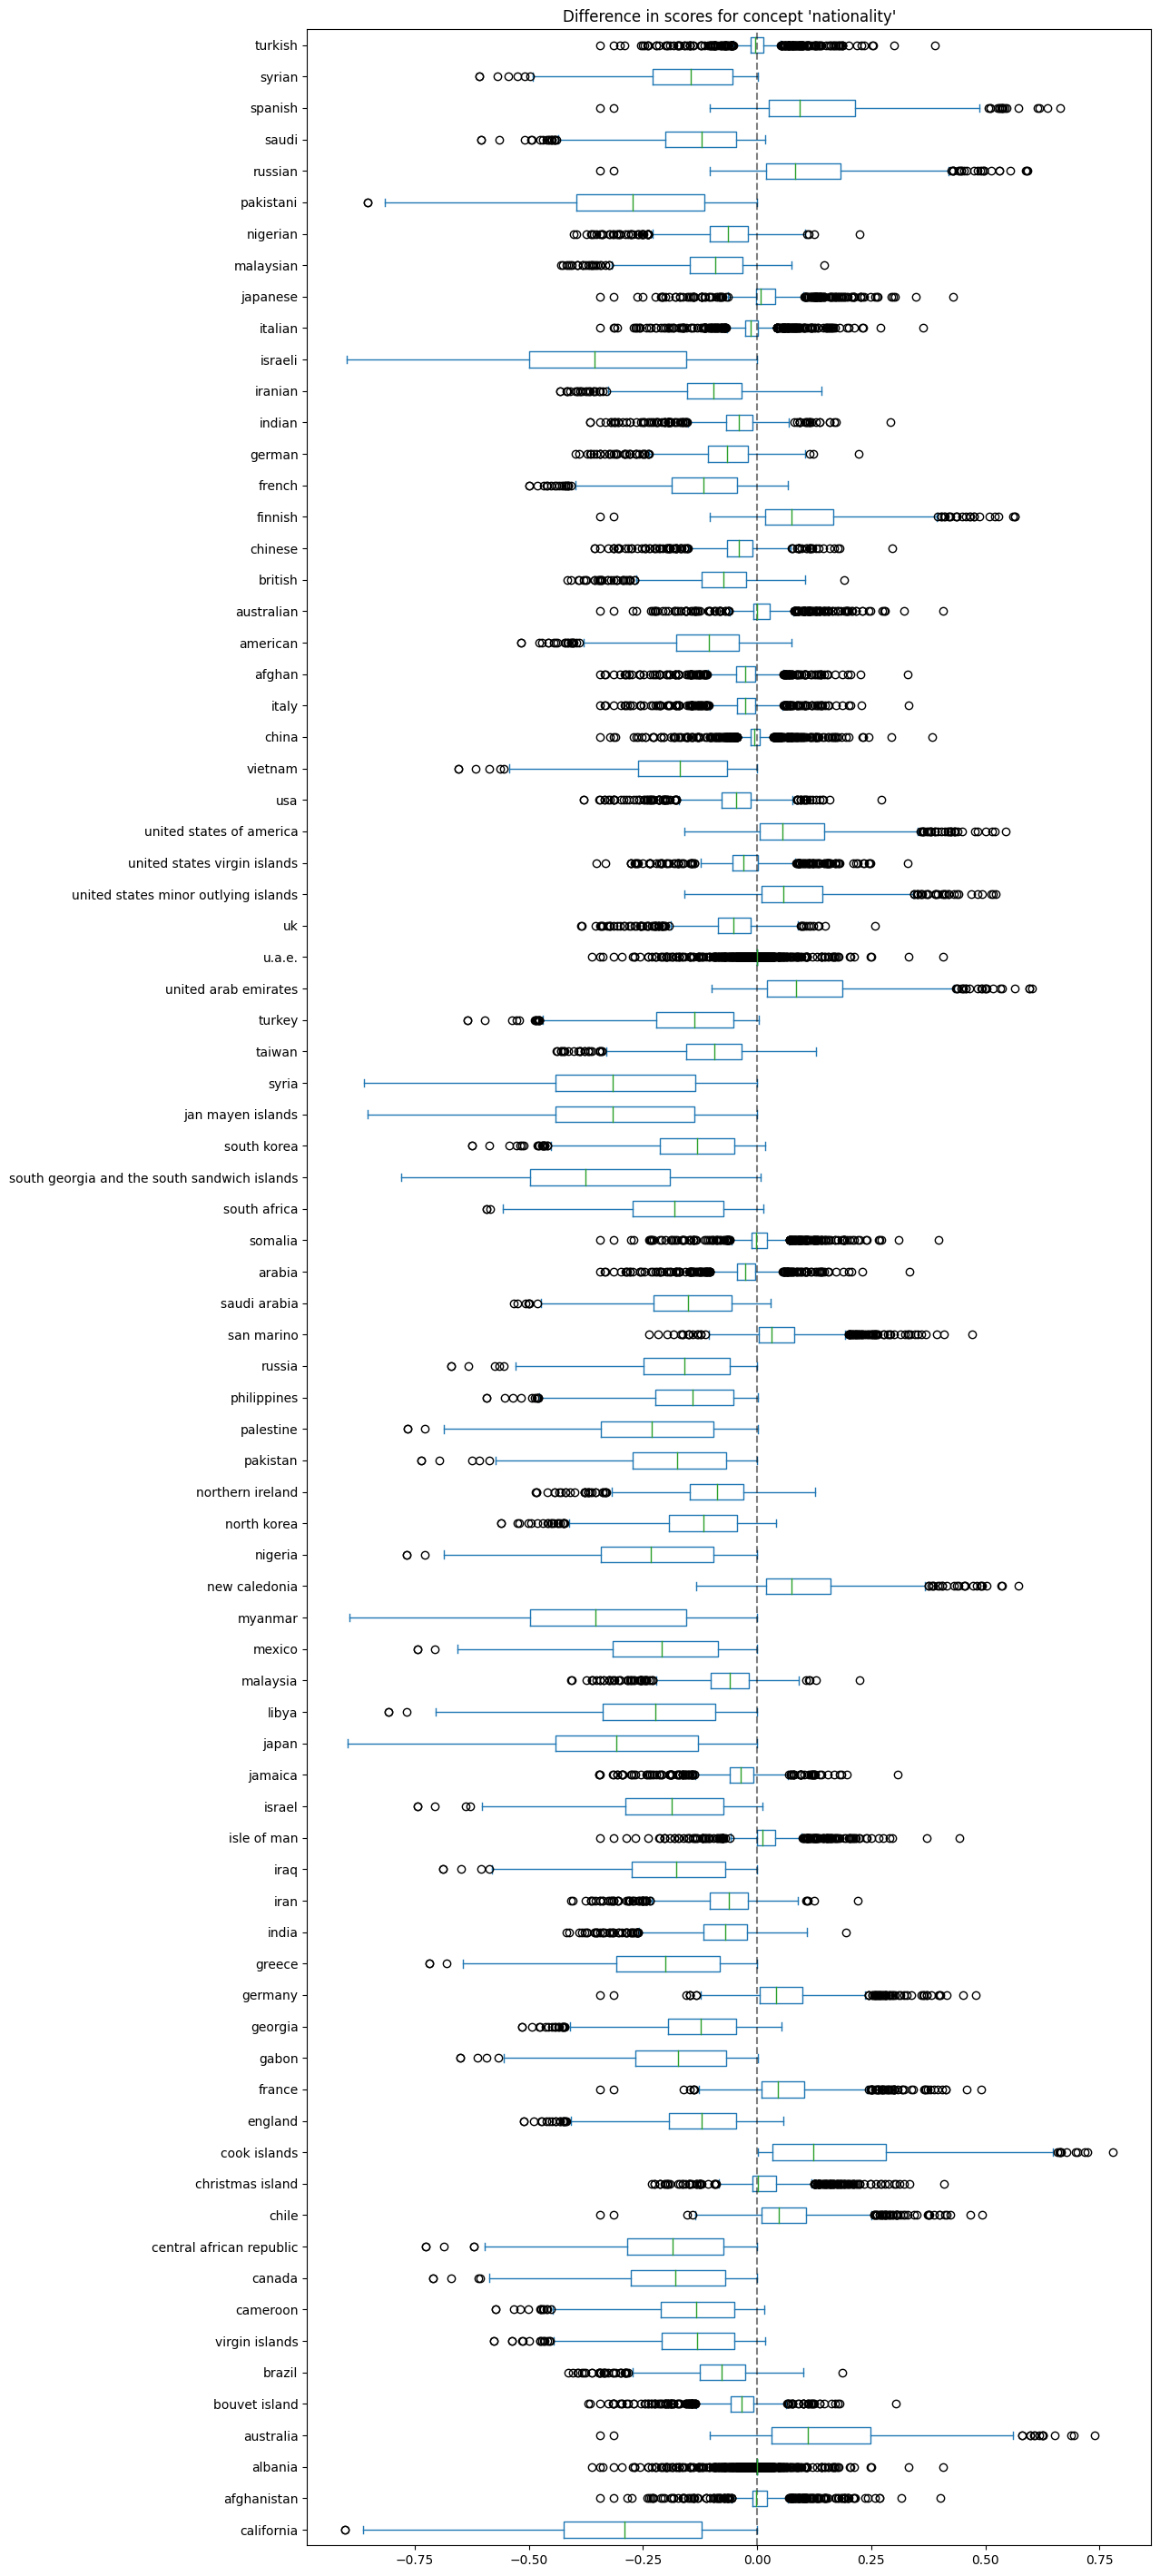

In [21]:
plot_scores(dataf=nationality_score_df, concept="nationality")